# 합성곱/폴링 계층 구현하기

## 4차원 배열

In [1]:
import numpy as np

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape

(1, 28, 28)

In [4]:
x[1].shape

(1, 28, 28)

In [5]:
x[0, 0].shape

(28, 28)

## 합성곱 계층 구현하기

In [6]:
from common.util import im2col, col2im

In [7]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
col1.shape

(9, 75)

In [8]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
col2.shape

(90, 75)

In [9]:
3*7*7

147

In [10]:
9*75

675

In [11]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx    

## 풀링 계층 구현하기

In [12]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# CNN 구현하기

In [13]:
from common.layers import Relu, Affine, SoftmaxWithLoss

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                conv_param={'filter_num':30, 'filter_size':5,
                           'pad':0, 'stride':1},
                hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']  
        input_size = input_dim[1]
        conv_output_size = int((input_size - filter_size + 2*filter_pad)/filter_stride) + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num, input_dim[0],
                                                           filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size, 
                                                           hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size, 
                                                           output_size)
        self.params['b3'] = np.zeros(output_size)    
        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                          self.params['b1'],
                                          conv_param['stride'],
                                          conv_param['pad'])
        self.layers['ReLu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y =self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]    
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        for layer in layers[::-1]:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db        
        
        return grads

In [14]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
# from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.3001999322483213
=== epoch:1, train acc:0.209, test acc:0.236 ===
train loss:2.2981348377814688
train loss:2.294188107002948
train loss:2.2895303669512264
train loss:2.286136801450867
train loss:2.2784584695403534
train loss:2.265787725564719
train loss:2.254712577812724
train loss:2.2367999050141805
train loss:2.2270752379285614
train loss:2.2071580998209437
train loss:2.2066494082021286
train loss:2.1444073518300364
train loss:2.1369778055999267
train loss:2.0844507535243455
train loss:2.049326061328435
train loss:2.0196620510098895
train loss:1.944217355071042
train loss:1.8993486688262047
train loss:1.8525784179830966
train loss:1.700228488075254
train loss:1.7144311449893883
train loss:1.6052881165441226
train loss:1.4565508409672625
train loss:1.4431663651020292
train loss:1.2868516262533312
train loss:1.3275355727456388
train loss:1.2439795208979867
train loss:1.073708176701351
train loss:0.9866768437188356
train loss:0.9938028713075373
train loss:0.9922119542531996

train loss:0.2187391382514649
train loss:0.1431145953149906
train loss:0.27565055362273444
train loss:0.26099475997273347
train loss:0.3247790231857745
train loss:0.27015233490850316
train loss:0.15156565651081536
train loss:0.21297341599034428
train loss:0.1722651875347675
train loss:0.2524295907211591
train loss:0.2540424918553345
train loss:0.14855241675219472
train loss:0.2734933784135952
train loss:0.22314182090494
train loss:0.24638657724095292
train loss:0.24780583656027683
train loss:0.16126051526506394
train loss:0.2573363883952743
train loss:0.23886074914081423
train loss:0.4500534195513042
train loss:0.2708206914175133
train loss:0.21164018779666782
train loss:0.3351594679227703
train loss:0.22457305379878473
train loss:0.20081172087597868
train loss:0.14624441758794157
train loss:0.173275910992443
train loss:0.1526680306045289
train loss:0.2165916169611947
train loss:0.3045092893138228
train loss:0.1813524109253126
train loss:0.3087246360973505
train loss:0.2230478997169049

train loss:0.06887994615106417
train loss:0.09861102867871145
train loss:0.10714559228339109
train loss:0.23448009531349867
train loss:0.1435302680393766
train loss:0.1060341540416579
train loss:0.1985939607986284
train loss:0.07108266768515367
train loss:0.13167332283238456
train loss:0.10132378406364348
train loss:0.0686443502092791
train loss:0.08584787756829951
train loss:0.17307572996723633
train loss:0.16684296089875844
train loss:0.18468236143146147
train loss:0.14311651790282132
train loss:0.0686598872831232
train loss:0.0684853499426428
train loss:0.1596213104788218
train loss:0.08134034247157507
train loss:0.08876376688913275
train loss:0.110752460909973
train loss:0.1053886265648098
train loss:0.22799647348748045
train loss:0.29309922597479576
train loss:0.12234871748058045
train loss:0.15347068734125066
train loss:0.13442562825081203
train loss:0.25904550404981813
train loss:0.18267473298743353
train loss:0.12307618026463402
train loss:0.13939810059029337
train loss:0.13991

train loss:0.18181311635855246
train loss:0.07566607265279073
train loss:0.0899051330082515
train loss:0.17739559015809991
train loss:0.14774589217384385
train loss:0.11866013932571084
train loss:0.0437400128299941
train loss:0.13067105098035442
train loss:0.09014475247950773
train loss:0.14937342577958815
train loss:0.06346365542916532
train loss:0.15148246022368417
train loss:0.09329953187413084
train loss:0.0787814351774598
train loss:0.04081618014014176
train loss:0.08175777132156084
train loss:0.13509570368427443
train loss:0.1497377329869497
train loss:0.3817110562613854
train loss:0.08772880375130948
train loss:0.12866552608138782
train loss:0.16904368128487327
train loss:0.09215745657818236
train loss:0.09186561297913784
train loss:0.07793209213521743
train loss:0.10573139274943039
train loss:0.05527145007985054
train loss:0.057625057419075726
train loss:0.08524847207847612
train loss:0.07613624237811631
train loss:0.10887633446672475
train loss:0.15287962644437772
train loss:0

train loss:0.08862518500383366
train loss:0.049360023453212915
train loss:0.10218935567280882
train loss:0.13466114340791885
train loss:0.03421789937531744
train loss:0.08421145957119247
train loss:0.06659893690247169
train loss:0.07432552361981973
train loss:0.061293296762677626
train loss:0.056540527087158975
train loss:0.04429838547760049
train loss:0.125973747561737
train loss:0.1354705443496203
train loss:0.11414707410061728
train loss:0.060254934673085056
train loss:0.10089735840942665
train loss:0.05779247739465083
train loss:0.07264657723996007
train loss:0.13125074859949634
train loss:0.08338756674840106
train loss:0.06881967263444552
train loss:0.040245244098533375
train loss:0.030614729787908038
train loss:0.0382243346779334
train loss:0.07248460021446024
train loss:0.07848688154196226
train loss:0.12622363296029337
train loss:0.033300130183351484
train loss:0.07784293658170893
train loss:0.06253795718675242
train loss:0.11446230800247845
train loss:0.0808856997164474
train 

train loss:0.03146050849909996
train loss:0.1984796006333848
train loss:0.045184989534311916
train loss:0.12817191267264597
train loss:0.09702421474708547
train loss:0.05400913014320732
train loss:0.041738247135734
train loss:0.04455877606137364
train loss:0.051349119346735216
train loss:0.021330985393053857
train loss:0.12217591116657879
train loss:0.06133431255047138
train loss:0.07189970316461917
train loss:0.03880010406144257
train loss:0.05130648258499723
train loss:0.07264599745641817
train loss:0.0423189206536567
train loss:0.047564186521266434
train loss:0.12213196867513795
train loss:0.10147407088654764
train loss:0.02540973697814386
train loss:0.040220661786988396
train loss:0.15298948673610183
train loss:0.10486357073909015
train loss:0.06823701934676701
train loss:0.07050373944913613
train loss:0.0316305155696667
train loss:0.06042891656697097
train loss:0.034164077516378726
train loss:0.08286776327963304
train loss:0.10111197260802021
train loss:0.05402824530531209
train l

train loss:0.039464178160446395
train loss:0.022131195058306522
train loss:0.04830818363331399
train loss:0.08469210370583624
train loss:0.12471743365901929
train loss:0.03202791957696017
train loss:0.0952906538672288
train loss:0.07231301937608238
train loss:0.11627614230831426
train loss:0.08895991834001535
train loss:0.017476075828416527
train loss:0.06430564747010202
train loss:0.07406763615260573
train loss:0.02946780519441592
train loss:0.08269175618822391
train loss:0.02914190492532922
train loss:0.08080332479559545
train loss:0.05434226958060157
train loss:0.04038272673678485
train loss:0.07340414069826905
train loss:0.027027354378068167
train loss:0.08368981660766626
train loss:0.09035913526463109
train loss:0.028207760894705572
train loss:0.13642126503792204
train loss:0.07696243055086488
train loss:0.03852490027944502
train loss:0.14978926975017834
train loss:0.0742843508701837
train loss:0.01887849565124381
train loss:0.07398996548858841
train loss:0.0294705436918604
train 

train loss:0.10075678168264476
train loss:0.045008861536999255
train loss:0.049507431241543276
train loss:0.007344560488440542
train loss:0.13342405189108159
train loss:0.03023677684441574
train loss:0.07668944511804594
train loss:0.14662349520098633
train loss:0.060618813024323884
train loss:0.023688923483492722
train loss:0.08985093529735684
train loss:0.04328624720810594
train loss:0.023741025976158462
train loss:0.04705656969349928
train loss:0.03751246684248241
train loss:0.030337983710012572
train loss:0.014230048406225009
train loss:0.11091062052867277
train loss:0.02769757532162276
train loss:0.02760645019704715
train loss:0.021327535100728316
train loss:0.012362136168538622
train loss:0.07427872216740901
train loss:0.022125422063325767
train loss:0.03821751339858235
train loss:0.054717255364535665
train loss:0.023766447701554165
train loss:0.12504441882700035
train loss:0.0662240812646574
train loss:0.025626395787067248
train loss:0.05710704544599485
train loss:0.0408427786884

train loss:0.06167754971460857
train loss:0.0336651348314062
train loss:0.03922946899510487
train loss:0.06788305526566324
train loss:0.06672085881568163
train loss:0.011848332595018878
train loss:0.06568359358247138
train loss:0.04415498492481142
train loss:0.040315475429527015
train loss:0.047945061726438566
train loss:0.03894859744400105
train loss:0.026802094280469056
train loss:0.03223268184425218
train loss:0.11422354188367417
train loss:0.03622455439947822
train loss:0.06199517816705193
train loss:0.010032224205302928
train loss:0.02148271597464146
train loss:0.1434789615407098
train loss:0.057334364155632686
train loss:0.014286569628449496
train loss:0.016738532904367335
train loss:0.03398714115148559
train loss:0.07481596398319722
train loss:0.019175898208206754
train loss:0.05137000679988419
train loss:0.09917980689310645
train loss:0.06566590353826113
train loss:0.06095374479246281
train loss:0.0253858021052252
train loss:0.017755867291930152
train loss:0.02155576264465877
t

train loss:0.045012530596073796
train loss:0.018085329402520205
train loss:0.03878775335555893
train loss:0.110634917256411
train loss:0.03019731284212803
train loss:0.019141575095732957
train loss:0.029948502650131475
train loss:0.06248959775360663
train loss:0.02532928606745618
train loss:0.011971023436857093
train loss:0.01645998528210042
train loss:0.014258067507272066
train loss:0.062435178446252675
train loss:0.004663853511110186
train loss:0.028933495056565638
=== epoch:5, train acc:0.984, test acc:0.981 ===
train loss:0.017883912084577614
train loss:0.03786721047202575
train loss:0.03406489787675722
train loss:0.085555070073956
train loss:0.014668916733816087
train loss:0.021671210683812586
train loss:0.02292523221842394
train loss:0.03750186499040096
train loss:0.011936761433864875
train loss:0.012726940312653928
train loss:0.029316813835751025
train loss:0.05658795937097709
train loss:0.02845565489475494
train loss:0.027621829965938892
train loss:0.02439169971040135
train los

train loss:0.01940413251085279
train loss:0.007604111926856604
train loss:0.07116905636671675
train loss:0.033788231895213273
train loss:0.1337566754404183
train loss:0.0516460428153728
train loss:0.0548127197113803
train loss:0.05499826824031552
train loss:0.009199053575236062
train loss:0.019012244230321895
train loss:0.03223645341322473
train loss:0.04563523039907246
train loss:0.10201621799908964
train loss:0.008747749072017929
train loss:0.009406953846868403
train loss:0.0640126814517224
train loss:0.050842549606967886
train loss:0.05572723023624377
train loss:0.030735528581363206
train loss:0.011896688961638402
train loss:0.029944748433856135
train loss:0.010858214988858465
train loss:0.016734525459202485
train loss:0.08684607935665385
train loss:0.024177241588561563
train loss:0.04938560471149675
train loss:0.018278387192729714
train loss:0.023941571763654267
train loss:0.0600409855934204
train loss:0.03990137245394683
train loss:0.02243845357550049
train loss:0.0189271249572775

train loss:0.07319417921871763
train loss:0.01351968404940622
train loss:0.015054559202101867
train loss:0.012319908907146135
train loss:0.03136991430100541
train loss:0.02975023061111697
train loss:0.0037783031147963853
train loss:0.058160693633332594
train loss:0.036627033218778485
train loss:0.008421257318556473
train loss:0.005039375383734458
train loss:0.018100357341430905
train loss:0.03773571155593957
train loss:0.07805791981093711
train loss:0.010962851067571206
train loss:0.00806866658411759
train loss:0.016544098305102097
train loss:0.0115059718169924
train loss:0.06470462676838289
train loss:0.023678547672090225
train loss:0.05935334833939244
train loss:0.018723702091853076
train loss:0.04781913634102328
train loss:0.04425740933753591
train loss:0.005268341484475532
train loss:0.01803429923958744
train loss:0.026910199933799384
train loss:0.04385260285449874
train loss:0.04059010357810517
train loss:0.004279342106541003
train loss:0.006420677527461783
train loss:0.0953979798

train loss:0.03024141245412935
train loss:0.012788183020309622
train loss:0.011271782072641196
train loss:0.009516493764745221
train loss:0.018091320244118345
train loss:0.022883326459505197
train loss:0.00786780041733618
train loss:0.029300820366210272
train loss:0.12465358635993237
train loss:0.03659292373448887
train loss:0.01123944286023014
train loss:0.007383504462707286
train loss:0.06834989132072956
train loss:0.021045523988888832
train loss:0.027192959132377154
train loss:0.014868805623048707
train loss:0.03887356439322645
train loss:0.003869022641288942
train loss:0.028407097617260336
train loss:0.025956489796699588
train loss:0.014897943537062591
train loss:0.0470854281863505
train loss:0.042357309199254026
train loss:0.047480384568023844
train loss:0.007507200346008897
train loss:0.004649645251532379
train loss:0.061137425119399035
train loss:0.0034236548695056597
train loss:0.014794452503407352
train loss:0.03513829253655944
train loss:0.030827424298743175
train loss:0.0628

train loss:0.013894960080880847
train loss:0.07743974815977504
train loss:0.002603903028997864
train loss:0.03188807682606624
train loss:0.06413211519695751
train loss:0.02109376032900755
train loss:0.009166016420262125
train loss:0.007307257446379222
train loss:0.119483994708395
train loss:0.043992152798759954
train loss:0.0521579638282678
train loss:0.011345081563038293
train loss:0.05410666848199493
train loss:0.007692518771944581
train loss:0.02940888136539911
train loss:0.013906461294378553
train loss:0.014298159273907865
train loss:0.09061477648687227
train loss:0.03186712493774406
train loss:0.020361990408576194
train loss:0.009644968384075575
train loss:0.008230871300942931
train loss:0.03356387962392879
train loss:0.040840841901105526
train loss:0.0077152251663229286
train loss:0.0027300706475746617
train loss:0.008151155869283855
train loss:0.01959018021072067
train loss:0.011163569299067817
train loss:0.09774344496175043
train loss:0.0048763129711614055
train loss:0.00766508

train loss:0.047329353009584116
train loss:0.003558910264527492
train loss:0.02274226144627542
train loss:0.07707551354047959
train loss:0.007070318567895814
train loss:0.01121546008337887
train loss:0.00448504756850372
train loss:0.016016965526750006
train loss:0.02870828796227092
train loss:0.012232053499921337
train loss:0.006487192845734509
train loss:0.008181441274536657
train loss:0.023438025377200637
train loss:0.008780917912788315
train loss:0.011281346163978016
train loss:0.032645223318962746
train loss:0.008559239307603179
train loss:0.010110534062538121
train loss:0.0298895474749199
train loss:0.01263372631722368
train loss:0.012831286394459834
train loss:0.03849112862274481
train loss:0.02210351606942277
train loss:0.03204053765412534
train loss:0.02953492157711374
train loss:0.01131077921617523
train loss:0.009086561714934754
train loss:0.006683879012368776
train loss:0.018840765364047038
train loss:0.01601531814330702
train loss:0.018264218979602818
train loss:0.059754886

train loss:0.03509827083286658
train loss:0.01799794682290211
train loss:0.0028304377939657606
train loss:0.044180655622415764
train loss:0.02656608858898862
train loss:0.007301037084847615
train loss:0.014157529272969458
train loss:0.023776380890727946
train loss:0.01174923734920231
train loss:0.008092258472329694
train loss:0.01214065392748397
train loss:0.016335675154096306
train loss:0.006245490313961282
train loss:0.034646743279115995
train loss:0.02507815924713203
train loss:0.007488654727898369
train loss:0.015955910460569208
train loss:0.009271787161318972
train loss:0.03435842142185293
train loss:0.037779742149879406
train loss:0.004053662378967033
train loss:0.008450217987674617
train loss:0.022174050351897075
train loss:0.027748116275795893
train loss:0.005471800371719976
train loss:0.07123593982327049
train loss:0.018932133035165066
train loss:0.015659204427208327
train loss:0.0016729464194787738
train loss:0.005738123712554005
train loss:0.004309969813166165
train loss:0.0

train loss:0.023016561410810002
train loss:0.0035455857876393383
train loss:0.011301349462048723
train loss:0.0034181514678756574
train loss:0.01327290137140587
train loss:0.015213514277872897
train loss:0.014822184098083023
train loss:0.013437403155012528
train loss:0.014774825984963089
train loss:0.004550325652693815
train loss:0.012513604758889463
train loss:0.030771749703598528
train loss:0.009587688297229205
train loss:0.00401947815400221
train loss:0.004418019721251869
train loss:0.0034934543200419443
train loss:0.016510499750907976
train loss:0.002786332850671343
train loss:0.008043057677288244
train loss:0.0049925574449558
train loss:0.030593097475884585
train loss:0.0077621440531460304
train loss:0.027006734212092046
train loss:0.004336572236055189
train loss:0.04243652093593525
train loss:0.023501883429858695
train loss:0.023520250151594313
train loss:0.005820936231022303
train loss:0.005317494330450489
train loss:0.0034821432064130607
train loss:0.009814898378512595
train lo

train loss:0.010589586023208544
train loss:0.009080860879205248
train loss:0.027850445812298345
train loss:0.039456160661207905
train loss:0.07471803474934123
train loss:0.03171253754318492
train loss:0.007383484988887171
train loss:0.005800384670838012
train loss:0.007928614120154139
train loss:0.005642394635699365
train loss:0.004818547695503055
train loss:0.008944253693441912
train loss:0.005921787024005562
train loss:0.013258324747812108
train loss:0.021253437001663492
train loss:0.0050042702590939415
train loss:0.00353723214489563
train loss:0.0039062421798944998
train loss:0.03187479001862088
train loss:0.030034621710765038
train loss:0.00414078888770661
train loss:0.001978664123531362
train loss:0.007852109342381081
train loss:0.014346788776248549
train loss:0.012356236993112462
train loss:0.005345010451569851
train loss:0.028205599518780326
train loss:0.00811498957773147
train loss:0.009902820756357527
train loss:0.003310130195388896
train loss:0.009807387031587124
train loss:0

train loss:0.034113964721352856
train loss:0.007760078052187027
train loss:0.0106057066897357
train loss:0.0160274751272474
train loss:0.00309397812205474
train loss:0.006807665160371779
train loss:0.002184200527011572
train loss:0.1266903987246857
train loss:0.011793962820004021
train loss:0.09926335401186226
train loss:0.019932789735241253
train loss:0.014829625374564573
train loss:0.005986524998574142
train loss:0.030038521151038746
train loss:0.024658038877458165
train loss:0.016582802843030046
train loss:0.012385789537496314
train loss:0.023840877223982457
train loss:0.0033893884365668947
train loss:0.014350927310021406
train loss:0.007822784894076259
train loss:0.03832711410327932
train loss:0.00655452202514795
train loss:0.013871559640173524
train loss:0.0026926309144814082
train loss:0.011042611011431384
train loss:0.05580569377038977
train loss:0.003642148672955735
train loss:0.006503968531107847
train loss:0.0027816081599911628
train loss:0.01150313838172017
train loss:0.0027

train loss:0.011599069313098424
train loss:0.00652328136410306
train loss:0.005778267408546235
train loss:0.0035658510335408343
train loss:0.006719320382707145
train loss:0.046715303994351844
train loss:0.014728610731151759
train loss:0.0011628003984285212
train loss:0.002963040710847217
train loss:0.014443751557690083
train loss:0.015999755098288854
train loss:0.007873814619943693
train loss:0.010023336701740547
train loss:0.00235717657779301
train loss:0.002157338086991745
train loss:0.008460491778514689
train loss:0.009527952925060791
train loss:0.004950625027635731
train loss:0.007676235583039942
train loss:0.050540053491184116
train loss:0.0030745421987141857
train loss:0.0010535918306510694
train loss:0.002546825702052913
train loss:0.0013916964422950261
train loss:0.0031940841311144993
train loss:0.00422593546459307
train loss:0.03732870007308739
train loss:0.004401404834457913
train loss:0.008823360084543772
train loss:0.04853807151097006
train loss:0.004639852334879537
train l

train loss:0.0242536317759774
train loss:0.01093533441097593
train loss:0.006063310070510727
train loss:0.005767182309679711
train loss:0.010042162324240909
train loss:0.005186389157652388
train loss:0.016870170058705065
train loss:0.01062595011960954
train loss:0.0026520938589697767
train loss:0.0018968613383930453
train loss:0.006387956192683072
train loss:0.004264367830446184
train loss:0.002713288011869631
train loss:0.0019277315070046974
train loss:0.0022998318432754248
train loss:0.01323547861827949
train loss:0.0024775699020784937
train loss:0.01994386657936008
train loss:0.05491722397392466
train loss:0.006926482664027154
train loss:0.01356983728877107
train loss:0.04371743532498721
train loss:0.0050638753109468445
train loss:0.005705779509471347
train loss:0.002669964560135165
train loss:0.02574933820441871
train loss:0.004636361122854847
train loss:0.017636240664674074
train loss:0.004281317972812145
train loss:0.02582246776146406
train loss:0.008781274413796036
train loss:0.

train loss:0.02887749711214844
train loss:0.03536625341126918
train loss:0.010644253669154606
train loss:0.0031056633368084187
train loss:0.005633708296266462
train loss:0.022962955350185152
train loss:0.004359788424387561
train loss:0.0015152069271528795
train loss:0.02589250835775611
train loss:0.005008113164467004
train loss:0.04911348362449327
train loss:0.013521494021095476
train loss:0.02267571802742987
train loss:0.011869362246891595
train loss:0.006297883389138976
train loss:0.004253169296220872
train loss:0.00976829982389277
train loss:0.013189445462885372
train loss:0.007370190944527008
train loss:0.023746643814393148
train loss:0.04704386549214929
train loss:0.007331406653181644
train loss:0.00554906097293345
train loss:0.020577739267346982
train loss:0.006760584303304087
train loss:0.017911829396750345
train loss:0.028160937913439384
train loss:0.011252057524597554
train loss:0.05810654587337678
train loss:0.018228522300638036
train loss:0.007040884745571987
train loss:0.00

train loss:0.004780218940865631
train loss:0.03737465884771585
train loss:0.007862181319876588
train loss:0.005033681239298979
train loss:0.012463592342682081
train loss:0.00565753645513579
train loss:0.016117540322994967
train loss:0.004482030711080192
train loss:0.015548539270672268
train loss:0.012600411817188071
train loss:0.0007914242830825572
train loss:0.006504127784095738
train loss:0.0018158283553977095
train loss:0.004806644051114629
train loss:0.0114952955067412
train loss:0.004827471677071098
train loss:0.009017270462726911
train loss:0.0063535162029846135
train loss:0.001208891170816584
train loss:0.012427402900337938
train loss:0.020061041413597883
train loss:0.0020921932621561826
train loss:0.03859962611624524
train loss:0.0005487193886271489
train loss:0.004574946698896884
train loss:0.0051748256227842
train loss:0.003021164827757685
train loss:0.0023620821883185076
train loss:0.08053317776424368
train loss:0.004379228916776281
train loss:0.007935883227086753
train loss

train loss:0.005928957247695344
train loss:0.11467599519786711
train loss:0.0009179697721916695
train loss:0.006542220068107432
train loss:0.013039555276746453
train loss:0.0017451283427753492
train loss:0.0035777318899834665
train loss:0.11065274661566947
train loss:0.0068189816669937805
train loss:0.011670658184207254
train loss:0.001643123154124829
train loss:0.0048944250726302915
train loss:0.00482832503381468
train loss:0.004084888479586283
train loss:0.007001818539738095
train loss:0.02457827913582763
train loss:0.0016359146523519164
train loss:0.013738658681058159
train loss:0.009111961806350221
train loss:0.022369929337724102
train loss:0.006486986728580358
train loss:0.004709130248027256
train loss:0.014120075036347055
train loss:0.005894683646596827
train loss:0.00338430364780062
train loss:0.0026731254278504458
train loss:0.0007068839761280092
train loss:0.00595447870231339
train loss:0.0036556394278254322
train loss:0.003495070246572843
train loss:0.0025330615876046902
trai

train loss:0.008341525271942261
train loss:0.006685068289068278
train loss:0.004760173560870908
train loss:0.0016314513246264584
train loss:0.015225414172342334
train loss:0.011606884172527344
train loss:0.0025655383194191374
train loss:0.044664141031311805
train loss:0.0018812643124975262
train loss:0.002045862164432392
train loss:0.002316856560073797
train loss:0.004569609771963764
train loss:0.004382124789353293
train loss:0.009594508936984238
train loss:0.029038014296892803
train loss:0.0029869001725856092
train loss:0.005384437559060454
train loss:0.004379164643372396
train loss:0.0017909473001791753
train loss:0.0008508835761553578
train loss:0.017829201247310352
train loss:0.003348106129740072
train loss:0.0026737514865444382
train loss:0.007041860190604944
train loss:0.17582329413022912
train loss:0.0018920551656183811
train loss:0.03472754849069942
train loss:0.0036289973213449777
train loss:0.005018817159476759
train loss:0.002461189242137071
train loss:0.0019315896564929256


train loss:0.008542891650983485
train loss:0.011076089457540617
train loss:0.013703453200091349
train loss:0.023556095236721645
train loss:0.008881763826696518
train loss:0.02038115718262556
train loss:0.004361171462253179
train loss:0.006636343920335177
train loss:0.016022101909159796
train loss:0.006122025828630498
train loss:0.00479994078104031
train loss:0.0009936732652784074
train loss:0.009128653375524145
train loss:0.002870632946708025
train loss:0.004954975933449474
train loss:0.008060950311036829
train loss:0.0017619123667321917
train loss:0.0005433271762476555
train loss:0.02180909014834855
train loss:0.01672555118353604
train loss:0.0012423320622652165
train loss:0.0020363806170559705
train loss:0.0031732410483523584
train loss:0.02411692961685584
train loss:0.021927933286685714
train loss:0.0037174560292708796
train loss:0.0008956917711979511
train loss:0.005120120329409322
train loss:0.008727757375938535
train loss:0.014061007744464575
train loss:0.0025278766094812707
trai

train loss:0.01517561246400568
train loss:0.0008869224613731538
train loss:0.011165132064659036
train loss:0.0035879837591052326
train loss:0.003388994928190313
train loss:0.10550999801900017
train loss:0.002334527726943784
train loss:0.0022024551723083467
train loss:0.0012295399972105708
train loss:0.00455882091877485
train loss:0.003072213817533059
train loss:0.0006707351637358244
train loss:0.009845131657904576
train loss:0.004036808627850014
train loss:0.0031057175583246383
train loss:0.004989647857415431
train loss:0.0029919778247589263
train loss:0.0040945190169246705
train loss:0.0008363087833427466
train loss:0.0041361011286240165
train loss:0.005910572736401379
train loss:0.004998468437728014
train loss:0.002102189673297074
train loss:0.0031422645749327434
train loss:0.0006713939530365407
train loss:0.005605795875867106
train loss:0.0010836180847271614
train loss:0.0034406706308930377
train loss:0.002579579874264838
train loss:0.0008649726929289048
train loss:0.004569356028580

train loss:0.003648501830178435
train loss:0.001339828486099317
train loss:0.004016597271838186
train loss:0.002375811454775198
train loss:0.027409224413094388
train loss:0.0011226238828724582
train loss:0.011211636734153279
train loss:0.010647358285082807
train loss:0.01344722144771364
train loss:0.006820455456172761
train loss:0.0013659334755266686
train loss:0.0024174888786063606
train loss:0.004286432768472589
train loss:0.008849581037354923
train loss:0.0061709222136059165
train loss:0.0016325544706279793
train loss:0.0026046493572414913
train loss:0.002210584357076281
train loss:0.003320992136918426
train loss:0.0029524325183828697
train loss:0.0037716712310041224
train loss:0.0016038370330739337
train loss:0.011109909501973684
train loss:0.0008197640237749539
train loss:0.0006420540046513082
train loss:0.027026761258771837
train loss:0.0022535716097180423
train loss:0.01481763379014694
train loss:0.018577998937435135
train loss:0.0018674079315871373
train loss:0.0049021933859808

train loss:0.0007032615556507706
train loss:0.0019141531665441008
train loss:0.0010836869915966346
train loss:0.002923421985278779
train loss:0.005713926980026493
train loss:0.011331600189361564
train loss:0.002164775438118194
train loss:0.005738285317477505
train loss:0.001492376002881675
train loss:0.0029881443364729926
train loss:0.03277748141414668
train loss:0.011176812372371754
train loss:0.005758325697655314
train loss:0.00016535658651974525
train loss:0.0034836378067671135
train loss:0.001375711557238722
train loss:0.007674773440486701
train loss:0.0032279563486892924
train loss:0.0026476927835386967
train loss:0.00027443536289023426
train loss:0.001901035477247714
train loss:0.0012116402685695175
train loss:0.0009438680723861262
train loss:0.0034569216647808865
train loss:0.0026457100337088963
train loss:0.0011618826543882846
train loss:0.0017425563709857037
train loss:0.005981118708190198
train loss:0.010220959133738605
train loss:0.004357114172751197
train loss:0.00430651430

train loss:0.0049276971282833084
train loss:0.0014457739260841603
train loss:0.01451346415863444
train loss:0.0086456631133851
train loss:0.004250804672168004
train loss:0.0006430012535514492
train loss:0.000546436215605458
train loss:0.00019421695637292133
train loss:0.0006007908133283999
train loss:0.003951103124864414
train loss:0.0010476486413167607
train loss:0.0022962834558351722
train loss:0.004125674374663214
train loss:0.007932157483647506
train loss:0.0015199931909772662
train loss:0.0018787096943822259
train loss:0.0020853091850522635
train loss:0.0009308769778945092
train loss:0.004206256273583512
train loss:0.009260163048771093
train loss:0.005925571534673024
train loss:0.0009375535555453543
train loss:0.0017426451775219148
train loss:0.015509482326940126
train loss:0.014195346538512107
train loss:0.002523006820057357
train loss:0.002874184753991518
train loss:0.005779030840011832
train loss:0.001482579288203892
train loss:0.004894284982078068
train loss:0.0090946596210218

train loss:0.016032740256034798
train loss:0.0008404604576836546
train loss:0.00755744248076545
train loss:0.002019493388339338
train loss:0.002373442794902932
train loss:0.007121732386107774
train loss:0.009919068842187618
train loss:0.004008134387545929
train loss:0.0019386005047983311
train loss:0.0010874675859486958
=== epoch:14, train acc:0.996, test acc:0.986 ===
train loss:0.0037836119633686406
train loss:0.0016998986253577487
train loss:0.01684374391251887
train loss:0.002277638265162882
train loss:0.0011074557317886135
train loss:0.0013870453888804727
train loss:0.007803162022142285
train loss:0.001746117774231018
train loss:0.0015332211709945436
train loss:0.0017557607052679158
train loss:0.005119956106184974
train loss:0.01009732902881685
train loss:0.001351984107372636
train loss:0.0013274161597679778
train loss:0.005072610868181568
train loss:0.0035757534918527045
train loss:0.0011969825565932217
train loss:0.0009941659548624942
train loss:0.0023654427230420296
train loss:

train loss:0.00699569494233361
train loss:0.001792494005137022
train loss:0.0034041067153426706
train loss:0.013345159499819044
train loss:0.0034436636767401813
train loss:0.008012231080562484
train loss:0.02112266927560997
train loss:0.002700470800082471
train loss:0.001136442162564407
train loss:0.03916389516455965
train loss:0.000956691458214442
train loss:0.013930104021465418
train loss:0.0020022488096685213
train loss:0.012829154749700753
train loss:0.00911875830353541
train loss:0.016081487990792447
train loss:0.0004900697792986905
train loss:0.008147747484319994
train loss:0.004067421669220354
train loss:0.0009919532285797702
train loss:0.006234454437451733
train loss:0.04042312208309696
train loss:0.0016802050377674091
train loss:0.004215854076292607
train loss:0.0034115338581861233
train loss:0.0050373325108218755
train loss:0.0012781900934429858
train loss:0.011199016760711717
train loss:0.0025269811657996004
train loss:0.0012522771874021457
train loss:0.003031308101520233
tr

train loss:0.007448984240502304
train loss:0.00986014044452149
train loss:0.003766758391124215
train loss:0.00041204632313433944
train loss:0.004806044764735188
train loss:0.0003274625319755476
train loss:0.0012074879390369705
train loss:0.0012499159547760589
train loss:0.0038521089757042703
train loss:0.0009245818142654515
train loss:0.0013576357835220862
train loss:0.0010990144683084957
train loss:0.012508433501028305
train loss:0.002510721552711213
train loss:0.02526602415337361
train loss:0.0012311435594961014
train loss:0.0014778389298578916
train loss:0.0011869719636954626
train loss:0.001419634542126778
train loss:0.005035366847305394
train loss:0.0029351050106966228
train loss:0.001301050888166672
train loss:0.00019271289486349667
train loss:0.002125235792058427
train loss:0.006481873900478969
train loss:0.003633956488116135
train loss:0.0020659203095293966
train loss:0.005333863005457204
train loss:0.012587805435218034
train loss:0.032084538613886396
train loss:0.0029118323992

train loss:0.0049305367091087675
train loss:0.0030075907015174636
train loss:0.0026582197201184877
train loss:0.001846081791200396
train loss:0.0009616695279206678
train loss:0.0010447642839944821
train loss:0.013804549287143659
train loss:0.004310661221433835
train loss:0.004242994808600211
train loss:0.0016121895941627227
train loss:0.006595815710319752
train loss:0.0012436416110680124
train loss:0.003202720568489551
train loss:0.0054880468156816575
train loss:0.00030858112529599536
train loss:0.005410001700099298
train loss:0.0015736841604162984
train loss:0.00033196347923959284
train loss:0.0004928487257022379
train loss:0.002386936434073198
train loss:0.004352625151980418
train loss:0.0008137175974260426
train loss:0.0010234724808312994
train loss:0.0024527064843104813
train loss:0.0015556780491744226
train loss:0.003387318942426909
train loss:0.0013298040148106583
train loss:0.004470090041256616
train loss:0.000370154142681225
train loss:0.0013730966572799764
train loss:0.0006245

train loss:0.001958874505555081
train loss:0.0020585371440392736
train loss:0.0033629664012874284
train loss:0.00020782831337367382
train loss:0.0024889770268473185
train loss:0.002962453438880083
train loss:0.0007436489312313697
train loss:0.001213355223332895
train loss:0.0029774126226160976
train loss:0.0012667185302660353
train loss:0.0003435641413967847
train loss:0.004630456642044684
train loss:0.0031085258552588134
train loss:0.007587482078366295
train loss:0.006220901797331453
train loss:0.0002496852326826979
train loss:0.0034576093708127433
train loss:0.011198142834028148
train loss:0.0011221895380860724
train loss:0.0016366888589151518
train loss:0.004413648735034801
train loss:0.0031528975000206204
train loss:0.001823213985115853
train loss:0.0028379058887435028
train loss:0.0010861747231521016
train loss:0.003587058898111195
train loss:0.0006645031532662091
train loss:0.0003140124955226345
train loss:0.0052367127348825525
train loss:0.0037650075355928473
train loss:0.002644

train loss:0.0011901104734742534
train loss:0.00034116992026943097
train loss:0.0019028563106718028
train loss:0.00508529212210128
train loss:0.002500245607367494
train loss:0.00021442501853487922
train loss:0.00026897904441445765
train loss:0.0009437320626149488
train loss:0.001764513592648693
train loss:0.0028393689405971216
train loss:0.0014355980757321995
train loss:0.008990512118808311
train loss:0.001023327338038659
train loss:0.0007224262721909294
train loss:0.0009929545492926987
train loss:0.00579545926681341
train loss:0.002156746992549195
train loss:0.0048376719477932475
train loss:0.021306341817301223
train loss:0.010451892323298817
train loss:0.0020521577304186585
train loss:0.0068676858237668136
train loss:0.0030898605421511845
train loss:0.00450516681641734
train loss:0.0005595435078295804
train loss:0.00039902970735211397
train loss:0.0008538540477586805
train loss:0.004555885785783144
train loss:0.007030760604769721
train loss:0.0015539589875526916
train loss:0.00142144

train loss:0.000349006031758732
train loss:0.0010376665697377158
train loss:0.0007421491292223829
train loss:0.0010510222997209147
train loss:0.0012114827550222002
train loss:0.0016737610784093998
train loss:0.0001980994142504366
train loss:0.0020145039747408475
train loss:0.0009902614790172428
train loss:0.0011803728470501614
train loss:0.0022302931071661357
train loss:0.0011736684843547194
train loss:0.00025960445300662665
train loss:0.003963154300771029
train loss:0.023571937187574745
train loss:0.010042779789547467
train loss:0.00020282746341238216
train loss:0.0002929053642577224
train loss:0.0008730783663745661
train loss:0.003036733438203606
train loss:0.00022852856822713655
train loss:0.002615744208668604
train loss:0.0003457606709479869
train loss:0.0008746925395283213
train loss:0.0006942962059351217
train loss:0.0020706824683011976
train loss:0.0019959830884457115
train loss:0.0006832798771006166
train loss:0.002032173622068067
train loss:0.0073061123426817485
train loss:0.0

train loss:0.0008629257384840415
train loss:0.001642199820247721
train loss:0.0003813065709279447
train loss:0.003006272950604723
train loss:0.0018947520005391334
train loss:0.01540072556389209
train loss:0.002217424397224971
train loss:0.005793645650269339
train loss:0.002149714567876824
train loss:0.005044132087397243
train loss:0.001722701214723491
train loss:0.0004935505114821384
train loss:0.0035039745040045963
train loss:0.0008490699109230145
train loss:0.007784764611447634
train loss:0.0004639377169750627
train loss:0.0007423470574007942
train loss:0.01231317458150305
train loss:0.0002416459694623036
train loss:0.0007468952449343333
train loss:0.0020612348444988883
train loss:0.0034743313969821167
train loss:0.0015818363495368728
train loss:0.0033963331528087098
train loss:0.0028323540863959863
train loss:0.00015790077123469928
train loss:0.0005444506154569297
train loss:0.0007955724197381395
train loss:0.003097907587975292
train loss:0.0018268664733276747
train loss:0.002805541

train loss:0.0011377596992128499
train loss:0.0006706855677371895
train loss:0.0007511567781569066
train loss:0.00030944644977082275
train loss:0.00031301266833658095
train loss:0.0013762146266748216
train loss:0.00016068964118718724
train loss:0.0003449867664344958
train loss:0.000492832506570989
train loss:0.0003336581513094242
train loss:0.0001198488038277786
train loss:0.00810813122012735
train loss:0.00030349779425761347
train loss:0.0006048572322296305
train loss:0.0002788732439858444
train loss:0.003343653991037149
train loss:0.025368041231997093
train loss:0.002637480847188954
train loss:0.004504579682269623
train loss:0.0012633024588358263
train loss:0.007667134055607591
train loss:0.004027573826167652
train loss:0.00011492420060788185
train loss:0.011491094653897837
train loss:0.0029935459193980215
train loss:0.006433404454516941
train loss:0.000759005749250799
train loss:0.002643114089943701
train loss:0.0002653991282011938
train loss:0.0017997819396562828
train loss:0.00019

train loss:0.00031661418481906614
train loss:0.007428935628993572
train loss:0.0004397073722442791
train loss:0.00024327501658317853
train loss:0.0023996692649819254
train loss:0.0009346589870407834
train loss:2.6849938173106398e-05
train loss:0.00011838423225272502
train loss:0.0013842545327493662
train loss:0.0016590823072058496
train loss:0.0008911125133671414
train loss:0.028951379166842952
train loss:0.0002160431338725471
train loss:0.0027224764113591413
train loss:0.0006415178358154532
train loss:0.0043253255746042414
train loss:0.0030641740120719413
train loss:0.0010715698975209114
train loss:0.0011117668553125677
train loss:0.002018372464826674
train loss:0.0007458662708715909
train loss:0.0002981280144898284
train loss:0.00016005935210235492
train loss:0.0011854451157635477
train loss:0.0013299190197916563
train loss:0.001444484123678178
train loss:0.0004374519851436888
train loss:0.0033246206838991087
train loss:0.0003364500407205106
train loss:0.00029572252433653507
train lo

train loss:0.0012739563810783277
train loss:0.0054490147364638
train loss:0.0030097521583079666
train loss:0.00395589052808057
train loss:0.0017807717284884683
train loss:5.4523009795507314e-05
train loss:8.913741990027087e-05
train loss:0.0030217945418516334
train loss:0.00572517898575931
train loss:0.0012000906048812096
train loss:0.002347643116098445
train loss:0.00013627049412390252
train loss:0.00011648022677966111
train loss:0.0005459991329113892
train loss:0.0012541784529538638
train loss:0.00797614868888364
train loss:0.003475918174228745
train loss:0.001256713176141392
train loss:0.0016169173519390062
train loss:0.0004100872459817873
train loss:0.0009418827066732958
train loss:0.0015734861897953433
train loss:0.0001280817141533586
train loss:0.0020172248568489305
train loss:0.00011826019176805206
train loss:0.0035666101423772432
train loss:3.284626708534694e-05
train loss:0.0025957748631064465
train loss:0.00010168761072214124
train loss:0.001917203461199074
train loss:0.00073

train loss:0.0023841261971116194
train loss:0.0007215952666566327
train loss:0.0008931520205547876
train loss:0.00027680212831593295
train loss:0.0016598607570110747
train loss:0.0001755422090371105
train loss:0.0019041723517170097
train loss:0.0037952186357627007
train loss:0.003815792233593928
train loss:0.0005865655236968288
train loss:0.020274993266578244
train loss:0.0006890020120446983
train loss:0.0008151374163414236
train loss:0.0027193140230699965
train loss:0.002603103127199699
train loss:0.0007296390403206424
train loss:0.0009362876996328617
train loss:0.0012839603097432228
train loss:0.0006373448881964119
train loss:0.010494759305050368
train loss:0.0013104857606211697
train loss:0.004212549538000281
train loss:0.0021193748643282117
train loss:0.006630347682741889
train loss:0.0031007409240171807
train loss:0.0031302937261037406
train loss:0.0013441880245373622
train loss:0.0018190506286167199
train loss:0.0007304059424789447
train loss:0.0027130441896251805
train loss:0.00

train loss:0.0037212584169045906
train loss:0.0033535339839674216
train loss:0.006258500438216312
train loss:0.00652283908654491
train loss:0.0009277963313632156
train loss:0.007422425343100821
train loss:0.006855817587214275
train loss:0.0008254089938892168
train loss:0.008443193245728745
train loss:0.0003045924269859496
train loss:0.062303812939647846
train loss:0.005807170295529226
train loss:0.0006868606410474831
train loss:0.0038047261946687365
train loss:0.0060072612026206215
train loss:0.0028823724571099057
train loss:0.0009695449324502716
train loss:0.007575211390111057
train loss:0.003278429256938761
train loss:0.002468193387683181
train loss:0.004167053093454786
train loss:0.002791358292175417
train loss:0.0008545797373800057
train loss:0.0009346102397799716
train loss:0.0013797437510579297
train loss:0.0019019948691610725
train loss:0.00041769695299790255
train loss:0.001439677947929087
train loss:0.0011009643217048228
train loss:0.000666930909530437
train loss:0.00165208187

train loss:0.0008329157429889793
train loss:8.28195014907818e-05
train loss:0.0007804792993767765
train loss:0.0029277545554090684
train loss:0.0018029500215402507
train loss:0.001052968047051696
train loss:0.002066842432446294
train loss:0.003248275882399066
train loss:0.0002644106993094001
train loss:0.0013172143473851722
train loss:6.273447248046865e-05
train loss:0.005628043534768701
train loss:0.00026605175964858834
train loss:7.70837826269184e-05
train loss:0.00028084552561633274
train loss:0.0011967613945466386
train loss:0.00010288517015639862
train loss:0.0021751503709765575
train loss:0.030298814303723144
train loss:7.631562887598155e-05
train loss:7.327019950901046e-05
train loss:6.504586178363234e-05
train loss:0.0021163771506502215
train loss:0.00026554247157913437
train loss:0.0022657621837670165
train loss:0.002037538861964179
train loss:0.00012402483966126142
train loss:0.001823014809630846
train loss:0.0001414996072209335
train loss:0.0022062606265014885
train loss:0.0

train loss:0.0010087718162054644
train loss:0.0028945587848192593
train loss:0.0006144722094992921
train loss:0.002215566038045127
train loss:5.638324008134802e-05
train loss:0.0008195584047948061
train loss:0.0016880974235953805
train loss:0.0019999264644262886
train loss:0.0004202106789662896
train loss:0.00040233247307591474
train loss:0.0010857553667808443
train loss:0.0004475877067270444
train loss:0.00023193352173047038
train loss:0.0028504824604694274
train loss:0.0013338185099792043
train loss:0.0023604007631137748
train loss:0.0013780369861745609
train loss:0.001932756456574454
train loss:0.0011906521553187882
train loss:0.0021136596157282595
train loss:0.0004591851687558472
train loss:0.00019484234984026253
train loss:0.0009084730341285175
train loss:0.038382178926163114
train loss:0.0011020134136924826
train loss:0.0030444046455227187
train loss:0.0005788243573345788
train loss:0.0054719748292745354
train loss:0.003608187788871059
train loss:0.0012557669072560571
train loss:

train loss:0.00027468434258253073
train loss:0.0004335177349133397
train loss:0.001721505665763711
train loss:0.0010267521341197367
train loss:0.0033492108537122012
train loss:0.00034306912587531423
train loss:0.00012222331166607598
train loss:0.0008056864571442223
train loss:0.000686333386879414
train loss:0.0029620352570361706
train loss:0.002344432530753241
train loss:0.0064877195637094865
train loss:0.000419072056297408
train loss:0.00032083289257407325
train loss:0.0014951466747035248
train loss:0.0009331492899255649
train loss:0.0011271611759903202
train loss:2.7067191927634952e-05
train loss:0.0029869572886477573
train loss:0.001200504434334609
train loss:0.0013582140350722994
train loss:0.00047997365876500464
train loss:0.00040224342477428805
train loss:0.004868721263187644
train loss:0.00010057531416259543
train loss:5.851731932776173e-05
train loss:0.0005276740184043901
train loss:0.002468536063288718
train loss:0.0001376867762975142
train loss:0.0009730635720088002
train los

train loss:0.0010552709881530165
train loss:0.001121471080738094
train loss:0.0004596085483028238
train loss:9.340148885290113e-05
train loss:0.000998895302434529
train loss:0.006668429891113311
train loss:4.396837611014663e-05
train loss:0.00041169605309530915
train loss:0.005505040402009367
train loss:0.0002788687528119913
train loss:0.001525021788790311
train loss:0.00029113135959176503
train loss:0.0026277369120529426
train loss:0.0003582008204024791
train loss:0.00011247502718528368
train loss:0.0007252653134280545
train loss:0.01399638386967401
train loss:0.002139236128906156
train loss:0.000595100900031558
train loss:0.001255875062098113
train loss:0.0006617129906416248
train loss:0.00028916685768064416
train loss:0.0002452147981550723
train loss:0.001459566928726183
train loss:0.0015773682219183114
train loss:0.0001914636311617114
train loss:0.005460454756770573
train loss:0.0002481160485695607
train loss:0.0032334631187351625
train loss:0.0013141088075875964
train loss:0.00196

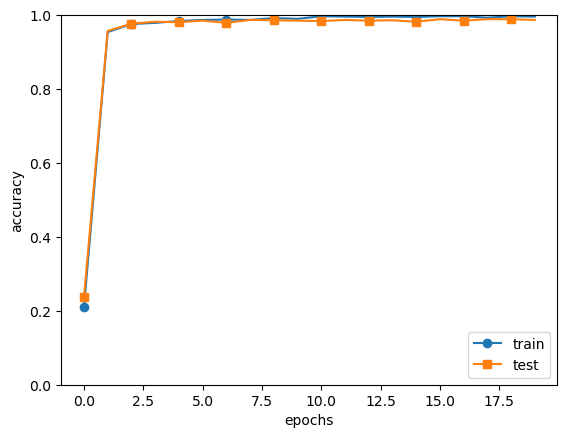

In [16]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()